In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt # plotting
%matplotlib inline 
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))

import sklearn # machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
print("xgboost version: {}". format(xgb.__version__))
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV # cross validation

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

matplotlib version: 3.4.0
seaborn version: 0.11.1
scikit-learn version: 0.24.1
xgboost version: 1.3.3
/kaggle/input/tabular-playground-series-apr-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2021/train.csv
/kaggle/input/tabular-playground-series-apr-2021/test.csv


# About
This is the first notebook I publish on Kaggle. It's for the Tabular Playground Series - April 2021 "Synthanic". I tried four different models (Logistic Regression, Decision Tree, Random Forest and XGB) with different preprocessing and evolving features. My best public score I got was 0.79341 with a Logistic Regression. Code for analysing the wrong predicions on the validation set and overwriting predicions for all lines with a Cabin is also included. 

In [2]:
df_train = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv') #the sample submission predicts everybody survived
df_all = df_train.append(df_test, ignore_index = True) # created because sometimes it is convenient to work on train and test set together

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


# 1 Quick baseline in order to know which score my model must beat 
# -> 0.78505
Note: this is based on previous knowledge of the original Titanic challenge. 

In [5]:
female_passengers = df_train[df_train.Sex == "female"]
print("Female passengers:\n", female_passengers.Survived.value_counts())
male_passengers = df_train[df_train.Sex == "male"]
print("Male passengers: \n", male_passengers.Survived.value_counts())

# pretend that all women survived
survived = (df_test.Sex == "female").astype('uint8')

# create submission file 
#submission = pd.DataFrame({
#    "PassengerId": df_test.PassengerId, 
#    "Survived": survived
#})
#submission.to_csv('submission.csv', index=False)

Female passengers:
 1    31226
0    12660
Name: Survived, dtype: int64
Male passengers: 
 0    44566
1    11548
Name: Survived, dtype: int64


# 2 EDA (Exploratory Data Analysis)

In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,49999.500000,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,28867.657797,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,24999.750000,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,49999.500000,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,74999.250000,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,99999.000000,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


In [7]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
df_train.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64

In [9]:
df_test.isna().sum()

PassengerId        0
Pclass             0
Name               0
Sex                0
Age             3487
SibSp              0
Parch              0
Ticket          5181
Fare             133
Cabin          70831
Embarked         277
dtype: int64

Column "Cabin" has more than half of the values missing. But the position of the Cabin might still give valuable information on survival, i.e. passengers from higher decks are more likely to reach the lifeboats (-> create feature). Drop column "Ticket" as it has nearly as many unique values as there are rows (and I can't make any sense of it). 
We have to deal with the missing values in "Age", "Fare" and "Embarked". Let's fill it with a median. To check which one let's explore how much the median varies if it is computed overall/ by Sex / by Pclass. 

In [10]:
df_all.groupby(["Sex","Pclass"]).agg({"Age":"mean","Fare":"mean","Embarked":pd.Series.mode})

Age        Fare Embarked
Sex    Pclass                                
female 1       41.974173  121.077621        C
       2       37.283031   27.353135        S
       3       27.222629   22.122209        S
male   1       39.537896   87.822340        S
       2       36.460753   23.993723        S
       3       31.365545   18.478564        S

## 2.1 Deal with missing values 
As shown above the mean varies between age and Plcass groups. So use the mean from the specific subgroup to replace missing values.

In [11]:
# for a Sex-Pclass combination replace the missing Ages/Fares/Embarked with the mean/mode
for sex in ["male","female"]:
    age_by_Pclass = df_all[df_all.Sex == sex].groupby(["Pclass"])["Age"].mean().round(2)
    fare_by_Pclass = df_all[df_all.Sex == sex].groupby(["Pclass"])["Fare"].mean().round(2)
    emb_by_Pclass = df_all[df_all.Sex == sex].groupby(["Pclass"])["Embarked"].agg(pd.Series.mode)

    for i in range(1,4):
        df_all.loc[(df_all.Sex == sex) & (df_all.Pclass == i) & df_all.Age.isna(),"Age"] = age_by_Pclass[i]
        df_all.loc[(df_all.Sex == sex) & (df_all.Pclass == i) & df_all.Fare.isna(),"Fare"] = fare_by_Pclass[i]
        df_all.loc[(df_all.Sex == sex) & (df_all.Pclass == i) & df_all.Embarked.isna(),"Embarked"] = emb_by_Pclass[i]

In [12]:
df_all.isna().sum()

PassengerId         0
Survived       100000
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket           9804
Fare                0
Cabin          138697
Embarked            0
dtype: int64

In [13]:
# this is an experiment with target encoding... I'm not convinced by it's usefulness, remove for now
#mean_sex = df_all[0:len(df_train)].groupby(["Sex"])["Survived"].mean()
#mean_deck = df_all[0:len(df_train)].groupby(["Deck"])["Survived"].mean()
#mean_embarked = df_all[0:len(df_train)].groupby(["Embarked"])["Survived"].mean()
#df_all["Sex"] = df_all["Sex"].map(mean_sex)
#df_all["Deck"] = df_all["Deck"].map(mean_deck)
#df_all["Embarked"] = df_all["Embarked"].map(mean_embarked)
#df_all.head()

In [14]:
df_2 = df_all.copy() # make a copy for the seperate deck experiment

## 2.2 Visualize Distribution

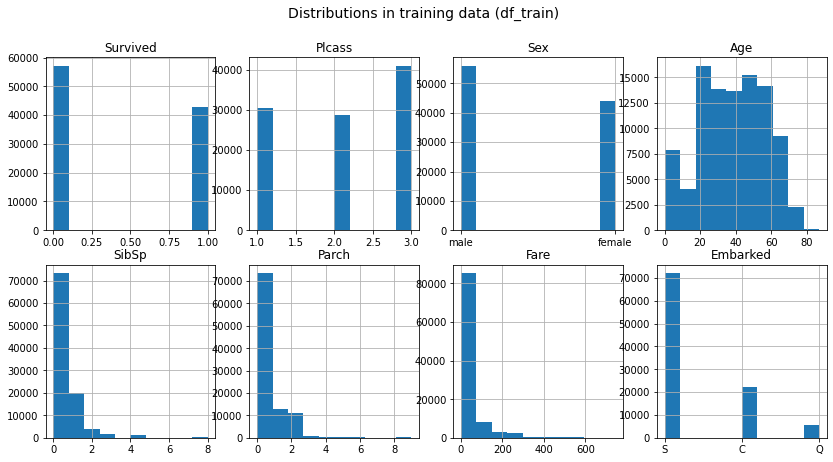

In [15]:
fig = plt.figure() # create figure
fsize = (14,7)
ax0 = fig.add_subplot(2, 4, 1) # add subplot 1 (2 rows, 4 columns, first plot)
ax1 = fig.add_subplot(2, 4, 2) 
ax2 = fig.add_subplot(2, 4, 3) 
ax3 = fig.add_subplot(2, 4, 4) 
ax4 = fig.add_subplot(2, 4, 5) 
ax5 = fig.add_subplot(2, 4, 6) 
ax6 = fig.add_subplot(2, 4, 7) 
ax7 = fig.add_subplot(2, 4, 8)

df_train.Survived.hist(figsize=fsize, ax=ax0)
df_train.Pclass.hist(figsize=fsize, ax=ax1)
df_train.Sex.hist(figsize=fsize, ax=ax2)
df_train.Age.hist(figsize=fsize, ax=ax3)
df_train.SibSp.hist(figsize=fsize, ax=ax4)
df_train.Parch.hist(figsize=fsize, ax=ax5)
df_train.Fare.hist(figsize=fsize, ax=ax6)
df_train.Embarked.hist(figsize=fsize, ax=ax7)

ax0.set_title("Survived")
ax1.set_title("Plcass")
ax2.set_title("Sex")
ax3.set_title("Age")
ax4.set_title("SibSp")
ax5.set_title("Parch")
ax6.set_title("Fare")
ax7.set_title("Embarked")
plt.suptitle("Distributions in training data (df_train)", fontsize=14)
plt.show()

In [16]:
# alternative, much shorter version to get the distributions. However this does not include the categorical variables. Could convert them before plotting...
#fsize = (10,12)
#plot_columns = ["Survived","Pclass","Sex", "Age","SibSp","Parch","Fare","Embarked" ]
#df_train[plot_columns].hist(figsize=fsize)
#plt.suptitle("Distributions in training data (df_train)", fontsize=14)
#plt.show()

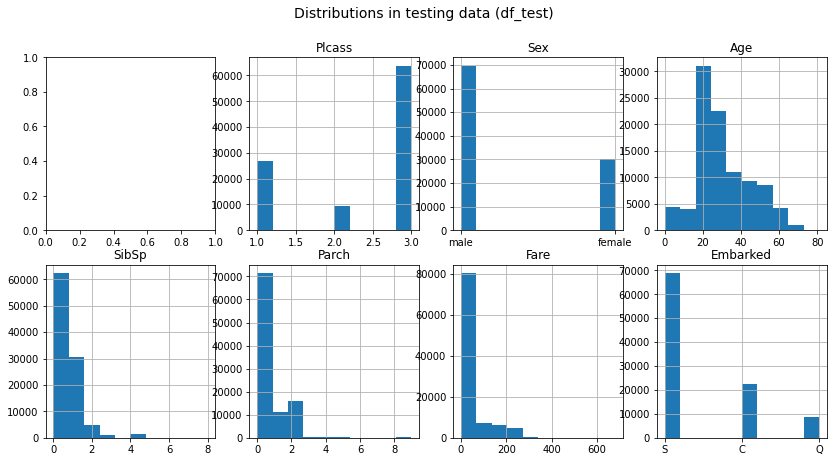

In [17]:
fig = plt.figure() # create figure
fsize = (14,7)
ax0 = fig.add_subplot(2, 4, 1) # add subplot 1 (2 rows, 4 columns, first plot)
ax1 = fig.add_subplot(2, 4, 2) 
ax2 = fig.add_subplot(2, 4, 3) 
ax3 = fig.add_subplot(2, 4, 4) 
ax4 = fig.add_subplot(2, 4, 5) 
ax5 = fig.add_subplot(2, 4, 6) 
ax6 = fig.add_subplot(2, 4, 7) 
ax7 = fig.add_subplot(2, 4, 8)

df_test.Pclass.hist(figsize=fsize, ax=ax1)
df_test.Sex.hist(figsize=fsize, ax=ax2)
df_test.Age.hist(figsize=fsize, ax=ax3)
df_test.SibSp.hist(figsize=fsize, ax=ax4)
df_test.Parch.hist(figsize=fsize, ax=ax5)
df_test.Fare.hist(figsize=fsize, ax=ax6)
df_test.Embarked.hist(figsize=fsize, ax=ax7)


ax1.set_title("Plcass")
ax2.set_title("Sex")
ax3.set_title("Age")
ax4.set_title("SibSp")
ax5.set_title("Parch")
ax6.set_title("Fare")
ax7.set_title("Embarked")
plt.suptitle("Distributions in testing data (df_test)", fontsize=14)
plt.show()

Most notable difference: In the test set the age distribution is different. So are Pclass and Sex ratio.

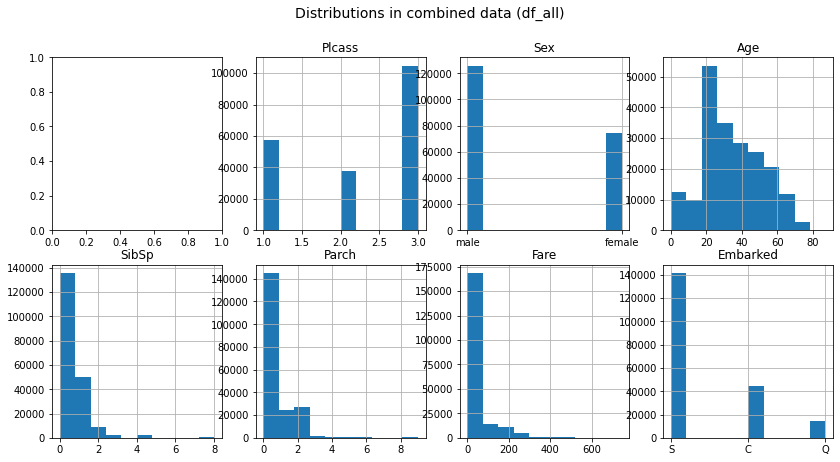

In [18]:
fig = plt.figure() # create figure
fsize = (14,7)
ax0 = fig.add_subplot(2, 4, 1) # add subplot 1 (2 rows, 4 columns, first plot)
ax1 = fig.add_subplot(2, 4, 2) 
ax2 = fig.add_subplot(2, 4, 3) 
ax3 = fig.add_subplot(2, 4, 4) 
ax4 = fig.add_subplot(2, 4, 5) 
ax5 = fig.add_subplot(2, 4, 6) 
ax6 = fig.add_subplot(2, 4, 7) 
ax7 = fig.add_subplot(2, 4, 8)

#df_all.Survived.hist(figsize=fsize, ax=ax0)
df_all.Pclass.hist(figsize=fsize, ax=ax1)
df_all.Sex.hist(figsize=fsize, ax=ax2)
df_all.Age.hist(figsize=fsize, ax=ax3)
df_all.SibSp.hist(figsize=fsize, ax=ax4)
df_all.Parch.hist(figsize=fsize, ax=ax5)
df_all.Fare.hist(figsize=fsize, ax=ax6)
df_all.Embarked.hist(figsize=fsize, ax=ax7)

#ax0.set_title("Survived")
ax1.set_title("Plcass")
ax2.set_title("Sex")
ax3.set_title("Age")
ax4.set_title("SibSp")
ax5.set_title("Parch")
ax6.set_title("Fare")
ax7.set_title("Embarked")
plt.suptitle("Distributions in combined data (df_all)", fontsize=14)
plt.show()

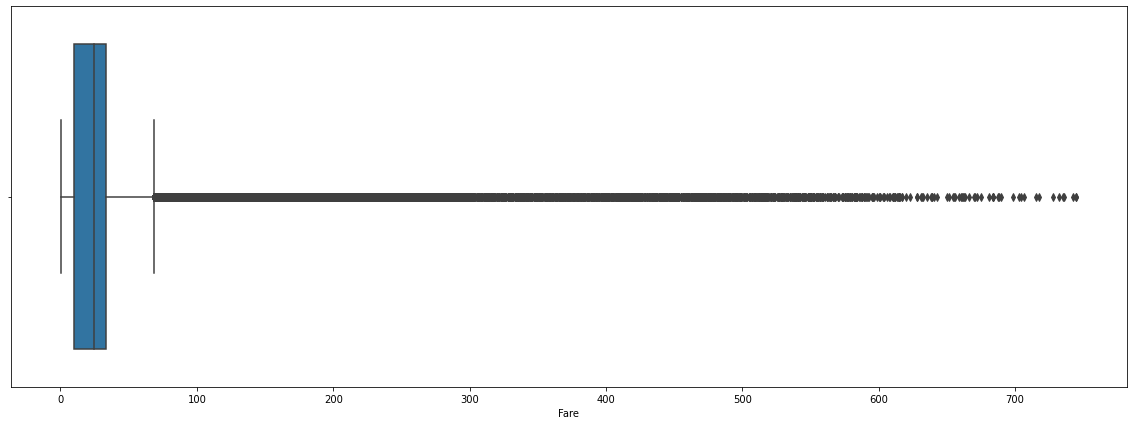

In [19]:
# let's have a different look at the fare column
fsize = (20,7)
fig = plt.figure(figsize=fsize) # create figure
ax0 = fig.add_subplot(1, 1, 1) # add subplot 1 (1 row, 1 columns, first plot)
sns.boxplot(x='Fare', data=df_train, ax=ax0)
plt.show()

# 3 Feature Engineering

In [20]:
#df_train[(df_train.Pclass == 1) & (df_train.Embarked == "S")].sort_values(by=["Name"]).head(25)
#df_train[(df_train.SibSp == 8)].sort_values(by=["Name"]).head(25)
df_all.sort_values(by="Name")[5:23]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
107056,107056,NaN,3,"Aadland, Timothy",male,62.0,1,1,NaN,10.67,NaN,S
117525,117525,NaN,3,"Aaron, Adrian",male,18.0,1,0,15802,10.66,NaN,S
191572,191572,NaN,3,"Aaron, April",female,18.0,0,0,20767,8.14,NaN,S
4378,4378,0.0,1,"Aaron, David",male,51.0,0,0,24368,63.43,NaN,S
35202,35202,0.0,3,"Aaron, Frederick",male,55.0,0,1,499692,32.28,NaN,S
72752,72752,0.0,3,"Aaron, James",male,37.0,4,6,4263162,29.25,E8462,S
106702,106702,NaN,2,"Aaron, James",male,40.0,0,0,8313,26.96,NaN,S
45388,45388,0.0,3,"Aaron, Joseph",male,51.0,0,0,26408,9.13,NaN,S
130669,130669,NaN,3,"Aaron, Leslie",male,21.0,0,0,3959168,8.74,NaN,S
42653,42653,1.0,2,"Aaron, Malcolm",male,51.0,0,0,9866,11.62,NaN,S


It seems, that unlike in the original dataset, the synthetic dataset has no "real" family relations. Let's see if it is completely useless to create features like in the original dataset.

Edit: it is not, the final score improved a bit after creating "is_alone" and "family_size".

In [21]:
# create new features
df_all["is_alone"] = 1
df_all.loc[(df_all.SibSp > 0) | (df_all.Parch > 0),["is_alone"]] = 0
df_all["family_size"] = df_all.SibSp + df_all.Parch + 1

In [22]:
df_all["Deck"]= df_all["Cabin"].str[0] # get the Deck from the Cabin number
df_all.loc[df_all.Deck.isna(), "Deck"] = "N" # treat the NaNs as a seperate category, maybe it means something for survival if the deck is unknown
df_all[0:len(df_train)].groupby("Deck").agg({"Deck":"count",'Survived': 'mean'}) # check survival rates per deck

,Deck,Survived
Deck,,
A,6307,0.274616
B,7439,0.630192
C,11825,0.712220
D,3637,0.732197
E,1749,0.617496
F,663,0.837104
G,482,0.836100
N,67866,0.342101
T,32,0.437500


In [23]:
# Decks F, G and T have few values, based on their survival rates I group them. 
df_all.loc[df_all.Deck == "G", "Deck"] = "F"
df_all.loc[df_all.Deck == "T", "Deck"] = "N"

In [24]:
df_all.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_alone,family_size,Deck
0,0,1.0,1,"Oconnor, Frankie",male,39.54,2,0,209245,27.14,C12239,S,0,3,C
1,1,0.0,3,"Bryan, Drew",male,31.37,0,0,27323,13.35,NaN,S,1,1,N
2,2,0.0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,0,4,N
3,3,0.0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,1,1,N
4,4,1.0,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,1,1,N


# 4 Data Preprocessing
Prepare data for modelling. 

For Logistic Regression: One hot encoding of categorical values ("Sex", "Embarked", "Deck"). Scale values to zero mean and same variance.

For Tree based models: One hot encoding of categorical values ("Sex", "Embarked", "Deck").

In [25]:
# drop unused columns
print(df_all.shape)
df_all.drop(columns=["Name","Cabin","Ticket"], inplace=True)    
print(df_all.shape)

(200000, 15)
(200000, 12)


In [26]:
# One Hot Encoding
df_all['Sex'].replace(to_replace=['male','female'], value=[1,0],inplace=True)
df_all = pd.get_dummies(df_all, columns= ["Embarked","Deck"])
df_all.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,is_alone,family_size,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_N
0,0,1.0,1,1,39.54,2,0,27.14,0,3,0,0,1,0,0,1,0,0,0,0
1,1,0.0,3,1,31.37,0,0,13.35,1,1,0,0,1,0,0,0,0,0,0,1
2,2,0.0,3,1,0.33,1,2,71.29,0,4,0,0,1,0,0,0,0,0,0,1
3,3,0.0,3,1,19.00,0,0,13.04,1,1,0,0,1,0,0,0,0,0,0,1
4,4,1.0,3,1,25.00,0,0,7.76,1,1,0,0,1,0,0,0,0,0,0,1


In [27]:
# let's bin the features "Age" and "Fare" and add a new binned column for them
no_bins = 6
df_all["Age_bin"] = pd.cut(df_all.Age,no_bins,labels=False)
df_all["Fare_bin"] = pd.cut(df_all.Fare,no_bins,labels=False)
df_all.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,is_alone,family_size,...,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_N,Age_bin,Fare_bin
0,0,1.0,1,1,39.54,2,0,27.14,0,3,...,1,0,0,1,0,0,0,0,2,0
1,1,0.0,3,1,31.37,0,0,13.35,1,1,...,1,0,0,0,0,0,0,1,2,0
2,2,0.0,3,1,0.33,1,2,71.29,0,4,...,1,0,0,0,0,0,0,1,0,0
3,3,0.0,3,1,19.00,0,0,13.04,1,1,...,1,0,0,0,0,0,0,1,1,0
4,4,1.0,3,1,25.00,0,0,7.76,1,1,...,1,0,0,0,0,0,0,1,1,0


In [28]:
df_all.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'is_alone', 'family_size', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_N', 'Age_bin', 'Fare_bin'],
      dtype='object')

In [29]:
# Mean normalization. I use the complete dataset here, but I am not sure yet if this is the correct place to do normalization
# is it better to do it for training, validation and test set seperately?
#columns = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked", "Deck", "is_alone", "family_size"]
#columns = ["Pclass","Sex","Age","SibSp","Parch","Fare","is_alone", "family_size","C","Q","S"]
columns = ['Pclass', 'Sex', 'SibSp','Parch', 'is_alone', 'family_size', 'Embarked_C','Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_N', 'Age_bin', 'Fare_bin']
print("columns: ", columns)
columns_n = []  # create columns names for the normalized columns
for i in columns:
    temp = i + "_n"
    columns_n.append(temp)
print("columns_n: ", columns_n)

scaler = StandardScaler() # all features are centered around 0 and have variance in the same order
temp = scaler.fit_transform(df_all[columns])
df_all = df_all.join(pd.DataFrame(data=temp, columns = columns_n)) # add normalized columns to df_all
df_all.head()

columns:  ['Pclass', 'Sex', 'SibSp', 'Parch', 'is_alone', 'family_size', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_N', 'Age_bin', 'Fare_bin']
columns_n:  ['Pclass_n', 'Sex_n', 'SibSp_n', 'Parch_n', 'is_alone_n', 'family_size_n', 'Embarked_C_n', 'Embarked_Q_n', 'Embarked_S_n', 'Deck_A_n', 'Deck_B_n', 'Deck_C_n', 'Deck_D_n', 'Deck_E_n', 'Deck_F_n', 'Deck_N_n', 'Age_bin_n', 'Fare_bin_n']


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,is_alone,family_size,...,Embarked_S_n,Deck_A_n,Deck_B_n,Deck_C_n,Deck_D_n,Deck_E_n,Deck_F_n,Deck_N_n,Age_bin_n,Fare_bin_n
0,0,1.0,1,1,39.54,2,0,27.14,0,3,...,0.643581,-0.26925,-0.290373,3.102922,-0.178236,-0.13512,-0.135618,-1.505182,0.122968,-0.294673
1,1,0.0,3,1,31.37,0,0,13.35,1,1,...,0.643581,-0.26925,-0.290373,-0.322277,-0.178236,-0.13512,-0.135618,0.664372,0.122968,-0.294673
2,2,0.0,3,1,0.33,1,2,71.29,0,4,...,0.643581,-0.26925,-0.290373,-0.322277,-0.178236,-0.13512,-0.135618,0.664372,-1.621944,-0.294673
3,3,0.0,3,1,19.00,0,0,13.04,1,1,...,0.643581,-0.26925,-0.290373,-0.322277,-0.178236,-0.13512,-0.135618,0.664372,-0.749488,-0.294673
4,4,1.0,3,1,25.00,0,0,7.76,1,1,...,0.643581,-0.26925,-0.290373,-0.322277,-0.178236,-0.13512,-0.135618,0.664372,-0.749488,-0.294673


# 5 Start Modelling
## 5.1 Setup Validation Scheme
I use holdhout validation as the number of training examples is much larger than the number of features.

In [30]:
# split df_all again in training and testing part
training_data = df_all[df_all.PassengerId<100000] # I dont overwrite df_train, df_train has still the values without encoding/normalization
testing_data = df_all[df_all.PassengerId>=100000]
training_data.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,is_alone,family_size,...,Embarked_S_n,Deck_A_n,Deck_B_n,Deck_C_n,Deck_D_n,Deck_E_n,Deck_F_n,Deck_N_n,Age_bin_n,Fare_bin_n
0,0,1.0,1,1,39.54,2,0,27.14,0,3,...,0.643581,-0.26925,-0.290373,3.102922,-0.178236,-0.13512,-0.135618,-1.505182,0.122968,-0.294673
1,1,0.0,3,1,31.37,0,0,13.35,1,1,...,0.643581,-0.26925,-0.290373,-0.322277,-0.178236,-0.13512,-0.135618,0.664372,0.122968,-0.294673


In [31]:
# split training data and target variable
y = training_data.Survived
X = training_data.drop(columns=["PassengerId","Survived"])

# split training set into training and validation part
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# now I have X_train with 80% of the rows and X_val with 20% of the rows

In [32]:
# quick check that there are a comparable percentage of survivers in the train and validation set, this should have been done by stratify=y
print(sum(y_train)/len(y_train))
print(sum(y_val)/len(y_val))

0.4277375
0.42775


In [33]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'is_alone',
       'family_size', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_N', 'Age_bin',
       'Fare_bin', 'Pclass_n', 'Sex_n', 'SibSp_n', 'Parch_n', 'is_alone_n',
       'family_size_n', 'Embarked_C_n', 'Embarked_Q_n', 'Embarked_S_n',
       'Deck_A_n', 'Deck_B_n', 'Deck_C_n', 'Deck_D_n', 'Deck_E_n', 'Deck_F_n',
       'Deck_N_n', 'Age_bin_n', 'Fare_bin_n'],
      dtype='object')

## 5.2.1 Train the first model: Logistic Regression

In [34]:
# initially without k-fold cross validation
clf = LogisticRegression()
clf.fit(X_train[columns_n], y_train) # use only the normalized columns for logistic regression
#clf.fit(X_train[limited_features], y_train)
# display the used parameters, regularization is on by default
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [35]:
# make a prediction
y_val_hat = clf.predict(X_val[columns_n]) # predicitions, 1dim np array
y_val_hat_pr = clf.predict_proba(X_val[columns_n]) # contains the probabilitys of the predictions 2dim np array

In [36]:
clf.score(X_val[columns_n], y_val) #  this the accuracy: number of correct predictions / number of predictions
#(sum((y_val_hat == 1) & (y_val ==1)) + sum((y_val_hat == 0) & (y_val ==0))) / len(y_val)
# previous: 0.76895
# 0.7687 with one hot encoding
# 0.76655 with Age and Fare as bins
# 0.77245 with Deck
# 0.77 with target encoded and normalized variables(v23)
# 0.77185 with limited features

0.77245

In [37]:
# alternative method to get the accurarcy score
accuracy_score(y_val, y_val_hat)

0.77245

In [38]:
# quick check if cross validation would be useful. As the resulting accuracy is not much different, I decide not.

#clf3 = LogisticRegression()
#scores = cross_val_score(clf3, X[columns_n], y, cv=5)
#scores

In [39]:
# find the best parameter for regularization
reg = [0.0001, 0.001, 0.01, 0.1, 1, 10]
result = []
for r in reg:
    print(r)
    clf = LogisticRegression(C=r)
    clf.fit(X_train[columns_n], y_train) # train on training set
    accuracy = clf.score(X_val[columns_n], y_val) # predict with validation set
    print(accuracy)
    result.append(accuracy)

print("\n The best accuracy score is: ", max(result))
index_of_best_score = result.index(max(result))
print(" with C: ", reg[index_of_best_score])

0.0001
0.77035
0.001
0.77175
0.01
0.7726
0.1
0.77245
1
0.77245
10
0.77245

 The best accuracy score is:  0.7726
 with C:  0.01


In [40]:
# make a prediction that can be submitted
clf = LogisticRegression(C=0.01)
clf.fit(X[columns_n], y) # retrain on whole dataset
y_hat = clf.predict(testing_data[columns_n]) # predict for test set
y_hat = y_hat.astype(int) # clf.predicts outputs float, which will give 0 score in submission

In [41]:
# check the thetas for each feature
pd.DataFrame({"Variable":X[columns_n].columns, "Weights": clf.coef_.round(2).reshape(-1)})

,Variable,Weights
0,Pclass_n,-0.42
1,Sex_n,-0.96
2,SibSp_n,-0.04
3,Parch_n,-0.04
4,is_alone_n,-0.10
5,family_size_n,-0.05
6,Embarked_C_n,0.27
7,Embarked_Q_n,-0.11
8,Embarked_S_n,-0.19
9,Deck_A_n,-0.28


In [42]:
# create final submission file
submission = pd.DataFrame({
    "PassengerId": df_test.PassengerId, 
    "Survived": y_hat
})
submission.to_csv('submission_logReg.csv', index=False)

# private score on Leaderboard
# 0.79337
# 0.79341 with binned Age and Fare
# 0.79183 using "Deck" and Target Encoding
# 0.79296 using "Deck"
# 0.78307 with limited features
# limited_features = ['Pclass_n', 'Sex_n','Embarked_C_n', 'Embarked_Q_n', 'Embarked_S_n','Deck_A_n', 'Deck_B_n', 'Deck_C_n', 'Deck_D_n', 'Deck_E_n', 'Deck_F_n','Deck_N_n', 'Age_bin_n', 'Fare_bin_n']

### 5.2.2 Try to predict survival of persons with known Cabin seperately

In [43]:
# let's try something: make a 2nd model and train it only for the rows having a "Deck"
mask = df_2.Cabin.isna()
df_2 = df_2[~mask]
df_2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1.0,1,"Oconnor, Frankie",male,39.54,2,0,209245,27.14,C12239,S
8,8,0.0,1,"Wardlaw, Michael",male,27.00,2,1,474849,73.02,A7253,S
9,9,0.0,2,"Greigo, Rudy",male,66.00,0,0,6981,9.14,D2969,C
11,11,0.0,1,"Telschow, Robert",male,60.00,0,0,19600,31.50,A9055,S
12,12,0.0,3,"Stewart, Pat",male,36.00,0,0,434108,9.34,C8674,S
...,...,...,...,...,...,...,...,...,...,...,...,...
199978,199978,NaN,1,"Hinaman, Dennis",male,23.00,0,0,28617,77.64,C11287,C
199991,199991,NaN,1,"Hood, Kathleen",female,37.00,0,0,27589,231.22,B9253,Q
199994,199994,NaN,1,"Floer, Bridgette",female,20.00,0,0,PC 22839,188.81,B19044,C
199998,199998,NaN,1,"Jacobsen, Margaret",female,49.00,1,2,PC 26988,29.68,B20828,C


In [44]:
# feature creation and preprocessing
# create new features
df_2["is_alone"] = 1
df_2.loc[(df_2.SibSp > 0) | (df_2.Parch > 0),["is_alone"]] = 0
df_2["family_size"] = df_2.SibSp + df_2.Parch + 1
df_2["Deck"]= df_2["Cabin"].str[0] # get the Deck from the Cabin number
df_2.loc[df_2.Deck.isna(), "Deck"] = "N" # treat the NaNs as a seperate category, maybe it means something for survival if the deck is unknown
#df_2[0:len(df_train)].groupby("Deck").agg({"Deck":"count",'Survived': 'mean'}) # check survival rates per deck
#df_2.loc[df_2.Deck == "G", "Deck"] = "F" # put small groups together
#df_2.loc[df_2.Deck == "T", "Deck"] = "F"
df_2.drop(columns=["Name","Cabin","Ticket"], inplace=True) 
df_2

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,is_alone,family_size,Deck
0,0,1.0,1,male,39.54,2,0,27.14,S,0,3,C
8,8,0.0,1,male,27.00,2,1,73.02,S,0,4,A
9,9,0.0,2,male,66.00,0,0,9.14,C,1,1,D
11,11,0.0,1,male,60.00,0,0,31.50,S,1,1,A
12,12,0.0,3,male,36.00,0,0,9.34,S,1,1,C
...,...,...,...,...,...,...,...,...,...,...,...,...
199978,199978,NaN,1,male,23.00,0,0,77.64,C,1,1,C
199991,199991,NaN,1,female,37.00,0,0,231.22,Q,1,1,B
199994,199994,NaN,1,female,20.00,0,0,188.81,C,1,1,B
199998,199998,NaN,1,female,49.00,1,2,29.68,C,0,4,B


In [45]:
# preprocessing
df_2['Sex'].replace(to_replace=['male','female'], value=[1,0],inplace=True)
df_2 = pd.get_dummies(df_2, columns= ["Embarked","Deck"])
df_2["Age_bin"] = pd.cut(df_2.Age,no_bins,labels=False)
df_2["Fare_bin"] = pd.cut(df_2.Fare,no_bins,labels=False)
df_2

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,is_alone,family_size,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Age_bin,Fare_bin
0,0,1.0,1,1,39.54,2,0,27.14,0,3,...,0,0,1,0,0,0,0,0,2,0
8,8,0.0,1,1,27.00,2,1,73.02,0,4,...,1,0,0,0,0,0,0,0,1,0
9,9,0.0,2,1,66.00,0,0,9.14,1,1,...,0,0,0,1,0,0,0,0,4,0
11,11,0.0,1,1,60.00,0,0,31.50,1,1,...,1,0,0,0,0,0,0,0,4,0
12,12,0.0,3,1,36.00,0,0,9.34,1,1,...,0,0,1,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199978,199978,NaN,1,1,23.00,0,0,77.64,1,1,...,0,0,1,0,0,0,0,0,1,0
199991,199991,NaN,1,0,37.00,0,0,231.22,1,1,...,0,1,0,0,0,0,0,0,2,1
199994,199994,NaN,1,0,20.00,0,0,188.81,1,1,...,0,1,0,0,0,0,0,0,1,1
199998,199998,NaN,1,0,49.00,1,2,29.68,0,4,...,0,1,0,0,0,0,0,0,3,0


In [46]:
columns = ['Pclass', 'Sex', 'SibSp','Parch', 'is_alone', 'family_size', 'Embarked_C','Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Age_bin', 'Fare_bin']
print("columns: ", columns)
columns_n = []  # create columns names for the normalized columns
for i in columns:
    temp = i + "_n"
    columns_n.append(temp)
print("columns_n: ", columns_n)

scaler = StandardScaler() # all features are centered around 0 and have variance in the same order
temp = scaler.fit_transform(df_2[columns])
df_2 = df_2.reset_index(drop=True) # reset index before join 
df_2 = df_2.join(pd.DataFrame(data=temp, columns = columns_n)) # add normalized columns to df_2

#df_2

columns:  ['Pclass', 'Sex', 'SibSp', 'Parch', 'is_alone', 'family_size', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Age_bin', 'Fare_bin']
columns_n:  ['Pclass_n', 'Sex_n', 'SibSp_n', 'Parch_n', 'is_alone_n', 'family_size_n', 'Embarked_C_n', 'Embarked_Q_n', 'Embarked_S_n', 'Deck_A_n', 'Deck_B_n', 'Deck_C_n', 'Deck_D_n', 'Deck_E_n', 'Deck_F_n', 'Age_bin_n', 'Fare_bin_n']


In [47]:
# split data before modelling
training_data_2 = df_2[df_2.PassengerId<100000] # I dont overwrite df_train, df_train has still the values without encoding/normalization
testing_data_2 = df_2[df_2.PassengerId>=100000]
y_2 = training_data_2.Survived
X_2 = training_data_2.drop(columns=["PassengerId","Survived"])
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42, stratify=y_2)

In [48]:
clf_2 = LogisticRegression()
clf_2.fit(X_train_2[columns_n], y_train_2) # use only the normalized columns for logistic regression
y_val_hat_2 = clf_2.predict(X_val_2[columns_n])
clf_2.score(X_val_2[columns_n], y_val_2) # accuracy score: 0.7560292515948343 - worse than I hoped for

0.7560292515948343

In [49]:
# find the best parameter for regularization
reg = [0.0001, 0.001, 0.01, 0.1, 1, 10]
result = []
for r in reg:
    print(r)
    clf_2 = LogisticRegression(C=r)
    clf_2.fit(X_train_2[columns_n], y_train_2) # train on training set
    accuracy = clf_2.score(X_val_2[columns_n], y_val_2) # predict with validation set
    print(accuracy)
    result.append(accuracy)

print("\n The best accuracy score is: ", max(result))
index_of_best_score = result.index(max(result))
print(" with C: ", reg[index_of_best_score])

0.0001
0.726155282402365
0.001
0.754317722109849
0.01
0.7561848451843785
0.1
0.7560292515948343
1
0.7560292515948343
10
0.7561848451843785

 The best accuracy score is:  0.7561848451843785
 with C:  0.01


In [50]:
# make a prediction that can be submitted
clf_2 = LogisticRegression(C=0.01)
clf_2.fit(X_2[columns_n], y_2) # retrain on whole dataset
y_hat_2 = clf_2.predict(testing_data_2[columns_n]) # predict for test set
y_hat_2 = y_hat_2.astype(int) # clf.predicts outputs float, which will give 0 score in submission

In [51]:
df_subset = pd.DataFrame({"PassengerId": testing_data_2.PassengerId, 
    "Survived": y_hat_2})
df_subset

,PassengerId,Survived
32134,100002,1
32135,100004,1
32136,100006,1
32137,100012,0
32138,100014,0
...,...,...
61298,199978,1
61299,199991,1
61300,199994,1
61301,199998,1


In [52]:
# create a dataframe with the original predictions from Log Reg and the new ones on the "Cabin subset"
df_both = submission.merge(df_subset, on="PassengerId", how="left")
df_both.columns= ["PassengerId", "y_hat", "y_hat_2"]

df_both

,PassengerId,y_hat,y_hat_2
0,100000,0,NaN
1,100001,1,NaN
2,100002,1,1.0
3,100003,0,NaN
4,100004,1,1.0
...,...,...,...
99995,199995,1,NaN
99996,199996,0,NaN
99997,199997,0,NaN
99998,199998,1,1.0


In [53]:
# when there is Nan in y_hat_2 because this row did not have a Cabin, take the value from the original prediction y_hat instead
df_both.loc[df_both.y_hat_2.isna(),"y_hat_2"] = df_both.y_hat
df_both.y_hat_2 = df_both.y_hat_2.astype(int)
print("Number of predictions that differ: ",df_both[df_both.y_hat != df_both.y_hat_2].shape[0])

Number of predictions that differ:  1170


In [54]:
# create submission file
submission = pd.DataFrame({
    "PassengerId": df_both.PassengerId, 
    "Survived": df_both.y_hat_2
})
submission.to_csv('submission_logReg_2.csv', index=False)

# unfortunatelly it did not help, in contrary it made the private score worse
# 0.79062 vs 0.79296

## 5.3 Second Model: Decision Tree

In [55]:
tree = DecisionTreeClassifier(criterion = "entropy", random_state=0)
tree.fit(X_train[columns],y_train) # use the not normalized columns for tree models
y_val_hat = tree.predict(X_val[columns])
print("Training accuracy: ", tree.score(X_train[columns],y_train))
print("Validation accuracy: ", tree.score(X_val[columns],y_val))
print("---")
print("with cross validation: ", cross_val_score(tree, X[columns], y, cv=5))

Training accuracy:  0.7980125
Validation accuracy:  0.76495
---
with cross validation:  [0.76375 0.7645  0.7663  0.7656  0.7679 ]


In [56]:
X_train[columns]

,Pclass,Sex,SibSp,Parch,is_alone,family_size,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Age_bin,Fare_bin
89638,3,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
69558,2,0,0,1,0,2,0,0,1,0,0,0,0,0,0,3,0
65174,2,0,0,0,1,1,0,0,1,0,0,0,0,0,0,3,0
14917,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,4,0
39928,3,1,0,0,1,1,0,0,1,0,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,1,0,0,2,0,3,0,0,1,0,0,1,0,0,0,2,0
66969,2,0,1,0,0,2,0,0,1,0,0,0,0,1,0,3,0
57737,2,0,0,2,0,3,0,0,1,0,0,0,0,0,0,2,0
42739,3,1,0,0,1,1,0,0,1,0,0,0,0,0,0,4,0


A tree with default parameters performs badly. Overfits to the training set. 

> columns = ["Pclass","Sex","Age","SibSp","Parch","Fare","is_alone", "family_size","C","Q","S"]

> Training accuracy:  0.994225
> Validation accuracy:  0.6847
> 
> with cross validation:  [0.68588 0.68956 0.68536 0.68344]

Overfitting is reduced when Age and Fare bins are used!

> columns = ["Pclass","Sex","Age_bin","SibSp","Parch","Fare_bin","is_alone", "family_size","C","Q","S"]

> Training accuracy:  0.7806
> Validation accuracy:  0.76045
> 
> with cross validation:  [0.76216 0.76216 0.76132 0.76056]

when "Deck" is used

> columns = ['Pclass', 'Sex', 'SibSp','Parch', 'is_alone', 'family_size', 'Embarked_C','Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_N', 'Age_bin', 'Fare_bin']
> 
> Training accuracy:  0.7980125
> Validation accuracy:  0.765
> 
> with cross validation:  [0.7638  0.76475 0.7655  0.76455 0.76765]

## 5.4 Third model: Random Forest (first ensemble model using bagging)

In [57]:
forest = RandomForestClassifier(criterion="gini", max_depth=5, min_samples_leaf = 2, random_state=0)
forest.fit(X_train[columns],y_train)
print("Training accuracy: ", forest.score(X_train[columns],y_train))
print("Validation accuracy: ", forest.score(X_val[columns],y_val))

# with default parameters:
# Training accuracy:  0.9938875
# Validation accuracy:  0.72675

# with max_depth=5
# Training accuracy:  0.770725
# Validation accuracy:  0.76895

# with max_depth=5 and min_samples_leaf = 2
# Training accuracy:  0.7707
# Validation accuracy:  0.76885

# using bins
# Training accuracy:  0.7689875
# Validation accuracy:  0.7675

# adding "Deck"
# Training accuracy:  0.7737375
# Validation accuracy:  0.774

Training accuracy:  0.7727625
Validation accuracy:  0.77255


In [58]:
# This is comparable to what I got from Logistic Regression. Let's retrain and make a submission.
forest = RandomForestClassifier(criterion="gini", max_depth=5, random_state=0)
forest.fit(X[columns],y)
y_hat = forest.predict(testing_data[columns])
y_hat = y_hat.astype(int)

In [59]:
# create final submission file
submission = pd.DataFrame({
    "PassengerId": df_test.PassengerId, 
    "Survived": y_hat
})
submission.to_csv('submission_forest.csv', index=False)

# private score on Leaderboard
# 0.78037
# 0.77823 with binned Age and Fare
# 0.79058 using "Deck" and Target Encoding
# 0.78380 using "Deck"

## 5.5 4th model: XGBoost (enseble mode using boosting)

In [60]:
X_train[columns].head()

,Pclass,Sex,SibSp,Parch,is_alone,family_size,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Age_bin,Fare_bin
89638,3,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
69558,2,0,0,1,0,2,0,0,1,0,0,0,0,0,0,3,0
65174,2,0,0,0,1,1,0,0,1,0,0,0,0,0,0,3,0
14917,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,4,0
39928,3,1,0,0,1,1,0,0,1,0,0,0,0,0,0,3,0


In [61]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train[columns], 
        y_train,
        verbose=True,
        ## the next three arguments set up early stopping.
        early_stopping_rounds=10,
        eval_metric='error',
        eval_set=[(X_val[columns], y_val)])

[0]	validation_0-error:0.22510
[1]	validation_0-error:0.22435
[2]	validation_0-error:0.22560


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-error:0.22555
[4]	validation_0-error:0.22535
[5]	validation_0-error:0.22545
[6]	validation_0-error:0.22520
[7]	validation_0-error:0.22550
[8]	validation_0-error:0.22560
[9]	validation_0-error:0.22495
[10]	validation_0-error:0.22395
[11]	validation_0-error:0.22350
[12]	validation_0-error:0.22435
[13]	validation_0-error:0.22430
[14]	validation_0-error:0.22380
[15]	validation_0-error:0.22395
[16]	validation_0-error:0.22405
[17]	validation_0-error:0.22395
[18]	validation_0-error:0.22375
[19]	validation_0-error:0.22370
[20]	validation_0-error:0.22365


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

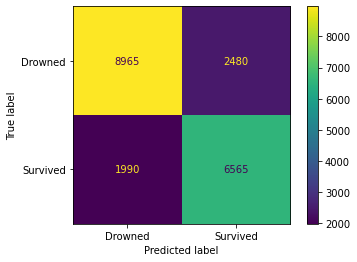

In [62]:
plot_confusion_matrix(clf_xgb, 
                      X_val[columns], 
                      y_val,
                      values_format='d',
                      display_labels=["Drowned", "Survived"]
                     )

In [63]:
# try to improve the classification accuracy with better hyperparameters
# Round 1
#param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'gamma': [0, 0.25, 1.0],
#     'reg_lambda': [0, 1.0, 10.0]
# }
# Output: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 0}
# Round 2
param_grid = {
     'max_depth': [4],
     'learning_rate': [0.1, 0.5, 1],
     'gamma': [0],
     'reg_lambda': [0, 0.5, 1]
 }
# Output: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 0}
#To speed up cross validiation, and to further prevent overfitting.
# We are only using a random subset of the data (90%) and are only
# using a random subset of the features (columns) (50%) per tree.
optimal_params = GridSearchCV(
     estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                 seed=42,
                                 subsample=0.9,
                                 colsample_bytree=0.5),
     param_grid=param_grid,
     scoring='accuracy', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
     verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
     n_jobs = 10,
     cv = 3
 )
# only uncomment if you want to run grid search again, time consuming!
#optimal_params.fit(X_train[columns], 
#        y_train,
#        verbose=False,
#        early_stopping_rounds=10,
#        eval_metric='error',
#        eval_set=[(X_val[columns], y_val)])
#print(optimal_params.best_params_)

In [64]:
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        gamma=0,
                        learning_rate=0.1, 
                        max_depth=4,
                        reg_lambda=0,
                        subsample=0.9,
                        colsample_bytree=0.5)
clf_xgb.fit(X_train[columns], 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='error',
            eval_set=[(X_val[columns], y_val)])

[0]	validation_0-error:0.29950
[1]	validation_0-error:0.23535
[2]	validation_0-error:0.24540
[3]	validation_0-error:0.26615
[4]	validation_0-error:0.26515
[5]	validation_0-error:0.26730
[6]	validation_0-error:0.26030


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-error:0.23325
[8]	validation_0-error:0.22890
[9]	validation_0-error:0.22565
[10]	validation_0-error:0.22740
[11]	validation_0-error:0.22780
[12]	validation_0-error:0.22845
[13]	validation_0-error:0.22980
[14]	validation_0-error:0.23105
[15]	validation_0-error:0.23065
[16]	validation_0-error:0.23165
[17]	validation_0-error:0.22770
[18]	validation_0-error:0.22635


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

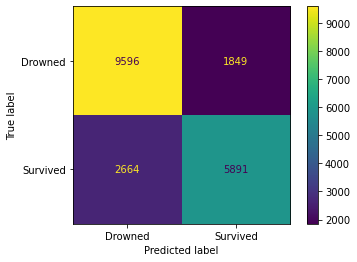

In [65]:
plot_confusion_matrix(clf_xgb, 
                      X_val[columns], 
                      y_val,
                      values_format='d',
                      display_labels=["Drowned", "Survived"]
                     )

Looks like there is no improvement with better hyperparameters.

In [66]:
y_val_hat = clf_xgb.predict(X_val[columns]).astype(int)
# get accuracy score on validation set like for the other models
accuracy_score(y_val, y_val_hat)

0.77435

In [67]:
# predict for testing data
y_hat = clf_xgb.predict(testing_data[columns]).astype(int)

In [68]:
# create final submission file
submission = pd.DataFrame({
    "PassengerId": df_test.PassengerId, 
    "Survived": y_hat
})
submission.to_csv('submission_xgb.csv', index=False)

# private score on Leaderboard
# 0.7834
# 0.78529 tuned
# 0.77000 with binned Age and Fare
# 0.79090 using "Deck" and Target Encoding
# 0.78630 using "Deck"

In [69]:
submission

,PassengerId,Survived
0,100000,0
1,100001,0
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1


# 6 Analysis of wrong predictions

This has been done with the predicitions from logistic regression. Code might have to be adapted when a tree model has been run.

In [70]:
# let's compare the ground truth with the predictions and prediction probabilities on the validation set
df_compare = pd.DataFrame({ 'y_val': y_val, 'y_val_hat': y_val_hat}).reset_index()
df_compare2 = pd.DataFrame(y_val_hat_pr)
df_compare = df_compare.join(df_compare2)
df_compare.head()

,index,y_val,y_val_hat,0,1
0,28761,0.0,0,0.879063,0.120937
1,61699,0.0,0,0.663505,0.336495
2,25028,0.0,0,0.811411,0.188589
3,72968,0.0,0,0.876444,0.123556
4,6432,0.0,0,0.523492,0.476508


In [71]:
# get the rows that have been incorectly classified (predicted) and look at them in the original unnormalized data
index_of_wrong_class = df_compare[df_compare.y_val != y_val_hat]["index"]
df_train.iloc[index_of_wrong_class].head(50)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
118,118,0,1,"Mcginnis, Linda",female,53.00,0,0,211125,102.26,A13305,Q
44959,44959,1,3,"Pancoast, Chris",male,57.00,0,0,NaN,9.20,NaN,S
17291,17291,0,2,"Smith, Brittany",female,72.00,0,0,47239,11.47,NaN,C
14207,14207,0,1,"Rounds, Diane",female,30.00,0,0,28721,352.23,B15677,Q
97873,97873,0,2,"Botcher, Arthur",male,49.00,0,0,315756,25.89,NaN,C
58772,58772,1,2,"Walkner, Herman",male,3.00,2,1,PP 440355,416.17,F9379,S
64046,64046,1,1,"Zecca, Hector",male,19.00,1,0,A/4 25021,178.34,C7478,S
18416,18416,1,3,"Walter, Catherine",female,6.00,1,2,11757,31.04,NaN,S
57282,57282,1,3,"Giroux, Clara",female,6.00,1,2,404517,31.97,NaN,S
1839,1839,1,3,"Rohlfing, Bernadette",female,22.50,0,0,NaN,21.99,NaN,S


Sadly, I can't see anything obvious here.